In [1]:
#!pip install scikit-plot
#!pip install seaborn -U

In [1]:
#import shap

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import yaml


from sklearn.preprocessing import normalize

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from scikitplot.metrics import plot_roc_curve

from churn_library import *

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [3]:
cpl = churn_pipeline()
cpl.import_data(r"./data/bank_data.csv")

#df = import_data(r"./data/bank_data.csv")
cpl.df.head()

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
with open("config.yaml", "r") as stream:
    config = yaml.safe_load(stream)

In [5]:
cpl.df[config['target']] = cpl.df['Attrition_Flag'].apply(
        lambda val: 0 if val == "Existing Customer" else 1)

## EDA

(10127, 23)
Unnamed: 0                  0
CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
Churn                       0
dtype: int64
         Unnamed: 0     CLIENTNUM  Customer_Age  Dependent_count  \
count  10127.000000  1.012700e+04  10127.000000     10127.000000   
mean    5063.000000  7.391776e+08     46.325960         2.346203   
std     2923.557422  3.690378e+07      8.016814         1.298908   
min        0.

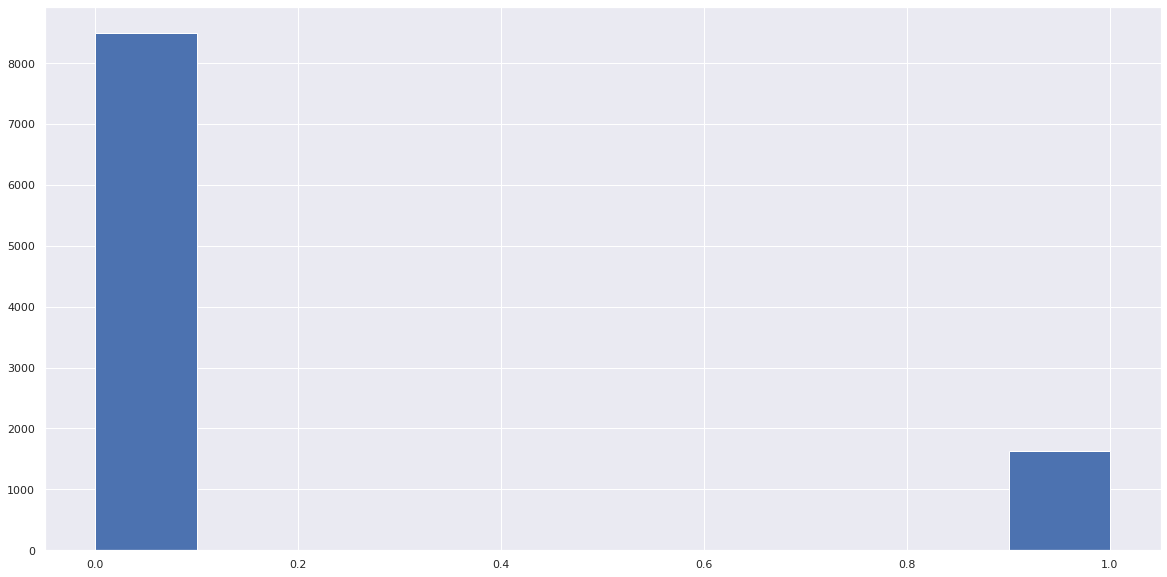

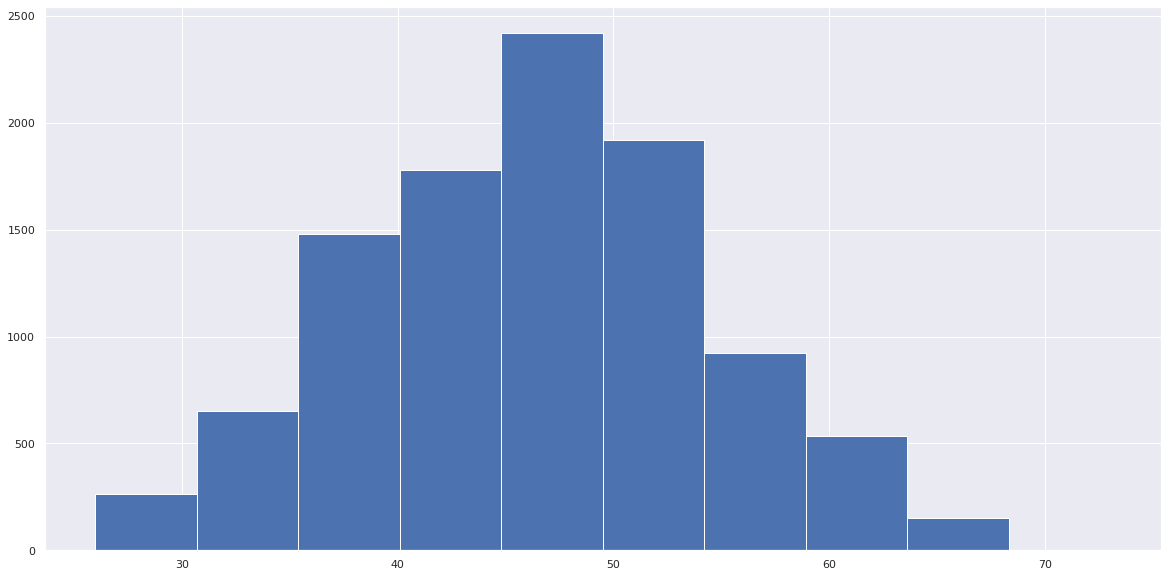

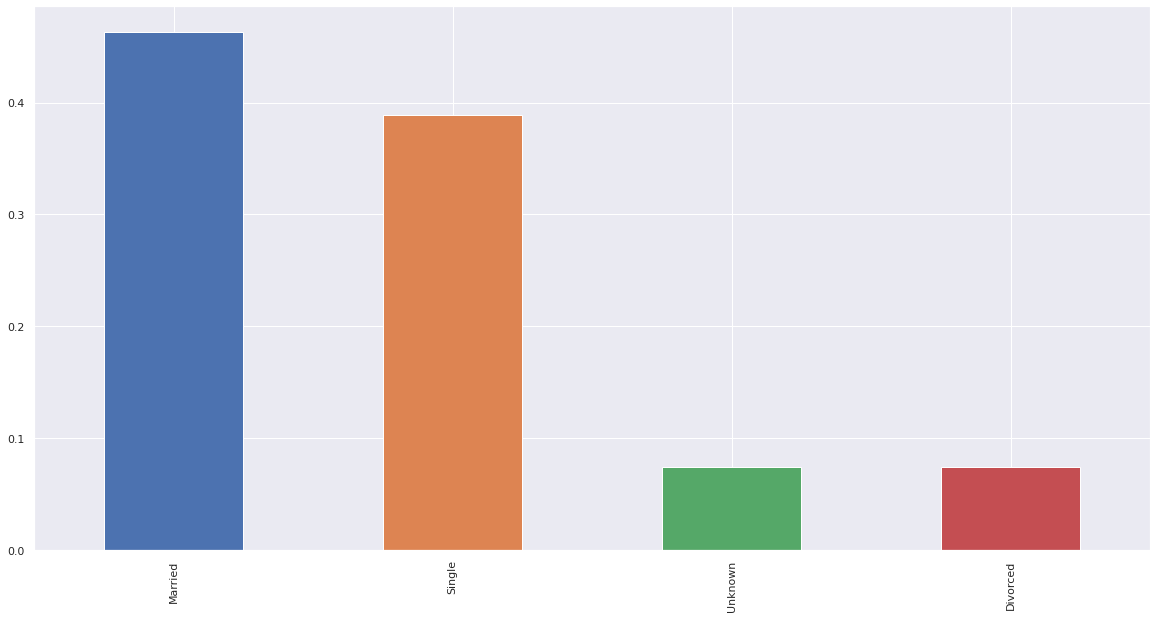

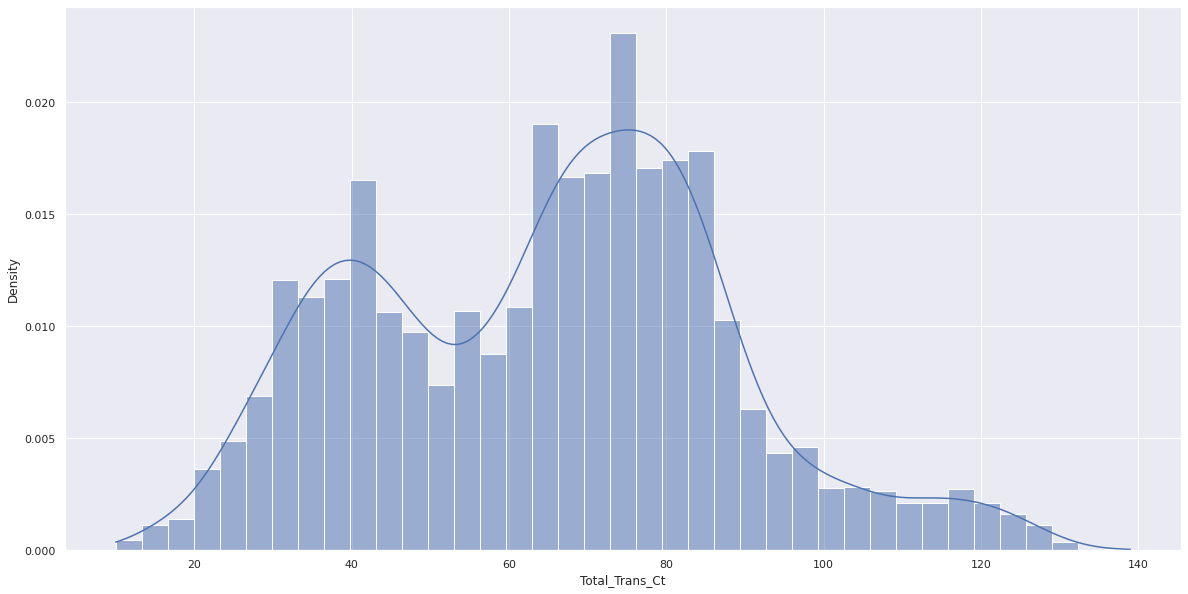

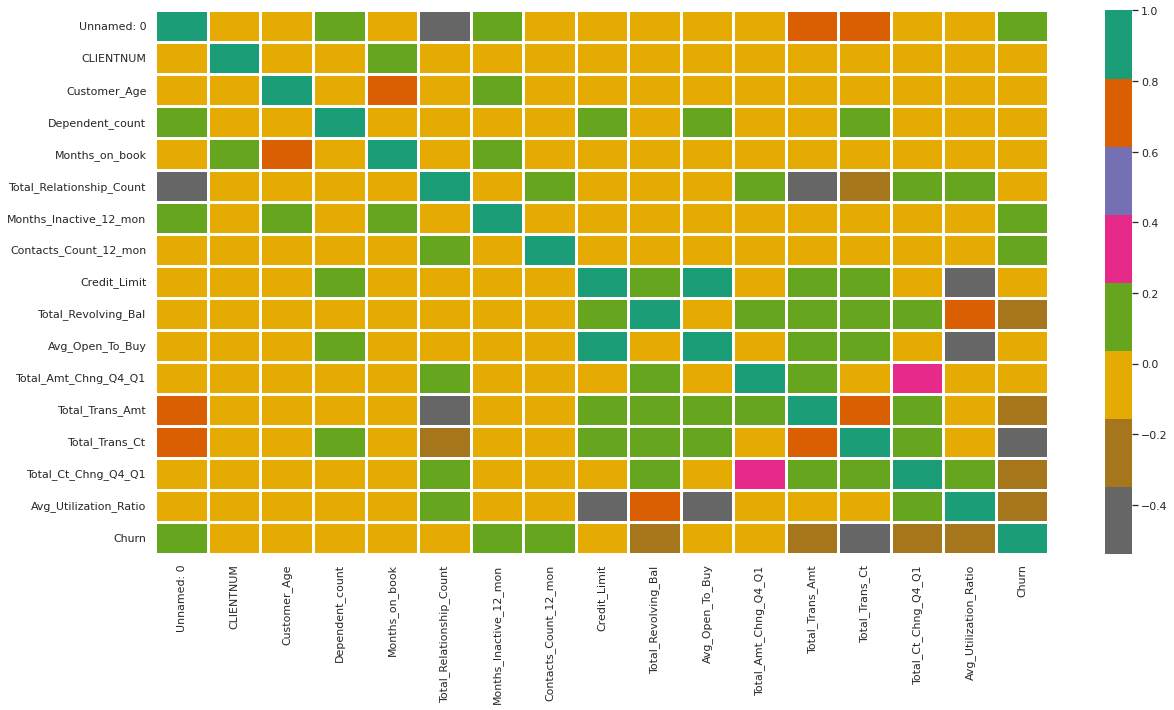

In [6]:
plot_dict = {'Churn': cpl.histogram,
             'Customer_Age':cpl.histogram,
             'Marital_Status': cpl.value_counts,
             'Total_Trans_Ct': cpl.distribution
            }

cpl.perform_eda(plot_dict)

## Feature engineering

In [7]:
X_train, X_test, y_train, y_test = cpl.perform_feature_engineering(
    config, 0.3
)

In [8]:
X_test.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
3781,48,3,39,4,3,4,2991.0,1508,1483.0,0.703,3734,64,0.882,0.504,0.173572,0.159381,0.169414,0.171862,0.160979
2922,59,1,53,5,5,4,2192.0,1569,623.0,0.706,4010,79,0.717,0.716,0.146152,0.159381,0.169414,0.171862,0.160979
5070,37,2,36,4,3,3,1734.0,987,747.0,0.879,4727,67,0.914,0.569,0.173572,0.155691,0.161765,0.171862,0.160979
7246,47,3,36,4,2,3,4786.0,1516,3270.0,0.940,4973,74,0.850,0.317,0.146152,0.210643,0.161765,0.151397,0.160979
623,42,3,33,3,3,2,3714.0,2170,1544.0,0.524,1454,35,0.522,0.584,0.146152,0.168532,0.169414,0.157655,0.160979


In [9]:
#param_grid = { 
#    'n_estimators': [200, 500],
#    'max_features': ['auto', 'sqrt'],
#    'max_depth' : [4,5,100],
#    'criterion' :['gini', 'entropy']
#}
param_grid = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [4],#,5,100],
    'criterion' :['gini']#, 'entropy']
}


cpl.train_models(param_grid)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


TypeError: len() of unsized object

In [ ]:
# grid search
rfc = RandomForestClassifier(random_state=42)
# Use a different solver if the default 'lbfgs' fails to converge
# Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lrc = LogisticRegression(solver='lbfgs', max_iter=3000)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,100],
    'criterion' :['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
cv_rfc.fit(X_train, y_train)

lrc.fit(X_train, y_train)

y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)

y_train_preds_lr = lrc.predict(X_train)
y_test_preds_lr = lrc.predict(X_test)

%store y_train_preds_rf
%store y_test_preds_rf
%store y_train_preds_lr
%store y_test_preds_lr
%store lrc
%store cv_rfc

In [11]:
%store -r y_train_preds_rf
%store -r y_test_preds_rf
%store -r y_train_preds_lr
%store -r y_test_preds_lr
%store -r lrc
%store -r cv_rfc

print(y_train_preds_rf)

[0 0 0 ... 0 0 0]


In [ ]:
cpl.classification_report_image(
    y_train_preds_lr,
    y_train_preds_rf,
    y_test_preds_lr,
    y_test_preds_rf
                               )

In [ ]:
lrc_plot = plot_roc_curve(lrc, X_test, y_test)

In [ ]:
# plots
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

In [17]:
# save best model
joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
joblib.dump(lrc, './models/logistic_model.pkl')

['./models/logistic_model.pkl']

In [18]:
rfc_model = joblib.load('./models/rfc_model.pkl')
lr_model = joblib.load('./models/logistic_model.pkl')

In [ ]:
lrc_plot = plot_roc_curve(lr_model, X_test, y_test)

In [ ]:
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc_model, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

In [21]:
explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

NameError: name 'shap' is not defined

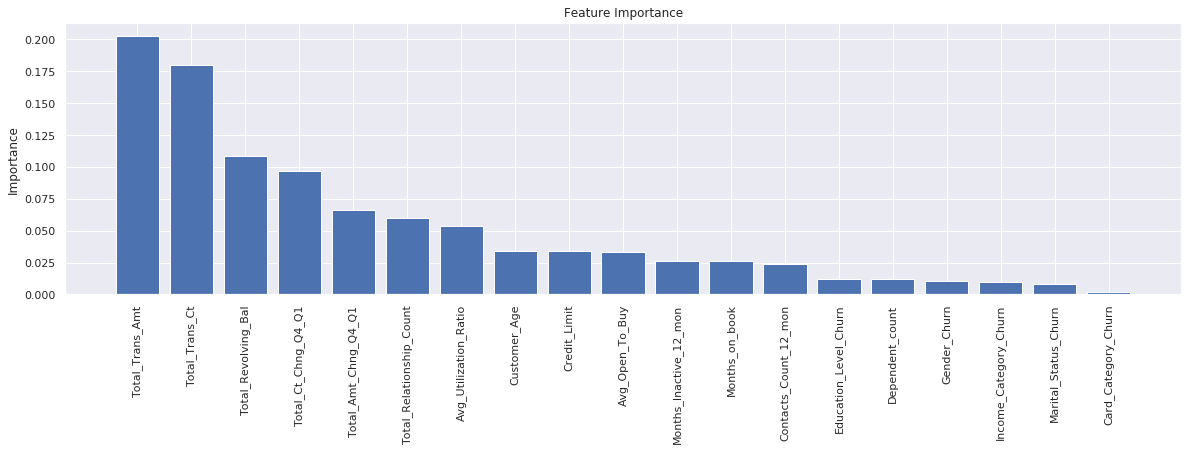

In [27]:
# Calculate feature importances
importances = cv_rfc.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,5))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90);

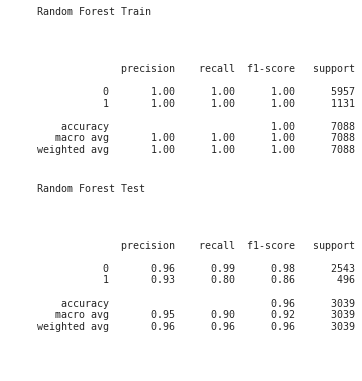

In [28]:
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');


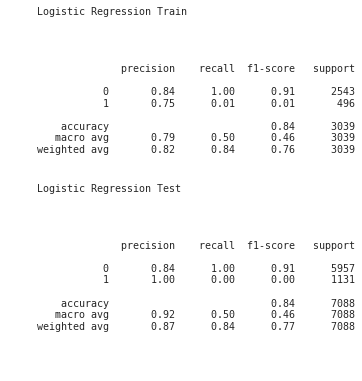

In [29]:
plt.rc('figure', figsize=(5, 5))
plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');